In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import draw, filters, io, transform, morphology, measure
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.patches as patches

# Function to draw an ellipse and return the image and its parameters
def draw_ellipse(shape=(32, 32)):
    image = np.zeros(shape)
    r = np.random.normal(shape[0] // 4, shape[0] // 4)
    asymmetry = np.random.normal(1, 1 / 8)
    center_x = np.random.normal(shape[0] // 2, shape[0] // 8)
    center_y = np.random.normal(shape[1] // 2, shape[1] // 8)
    rotation = np.random.uniform(0, 2 * np.pi)
    rr, cc = draw.ellipse(center_x, center_y, r, asymmetry * r, shape=shape, rotation=rotation)
    image[rr, cc] = 1
    image = filters.gaussian(image, sigma=np.random.uniform(0, 3))
    
    return image, r, asymmetry, (center_x, center_y), rotation

# Generate dataset
def generate_dataset(num_samples=1000, shape=(32, 32)):
    images, radii, asymmetries, positions, rotations = [], [], [], [], []
    
    for _ in range(num_samples):
        image, r, asymmetry, position, rotation = draw_ellipse(shape)
        images.append(image)
        radii.append(r)
        asymmetries.append(asymmetry)
        positions.append(position)
        rotations.append(rotation)
    
    images = np.array(images).reshape(-1, shape[0], shape[1], 1)
    radii = np.array(radii)
    asymmetries = np.array(asymmetries)
    positions = np.array(positions)
    rotations = np.array(rotations)
    
    return images, radii, asymmetries, positions, rotations

# Create the CNN model
def create_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(5)  # Output layer with 5 neurons for radius, asymmetry, position (x, y), and rotation
    ])
    
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

# Generate the dataset
images, radii, asymmetries, positions, rotations = generate_dataset(num_samples=50000, shape=(32, 32))

# Normalize images
images = images / np.max(images)

# Combine radii, asymmetries, and positions into a single array for the labels
labels = np.hstack([radii.reshape(-1, 1), asymmetries.reshape(-1, 1), positions, rotations.reshape(-1, 1)])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Create and train the model
model = create_model(input_shape=(32, 32, 1))
model.summary()
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 128)               2

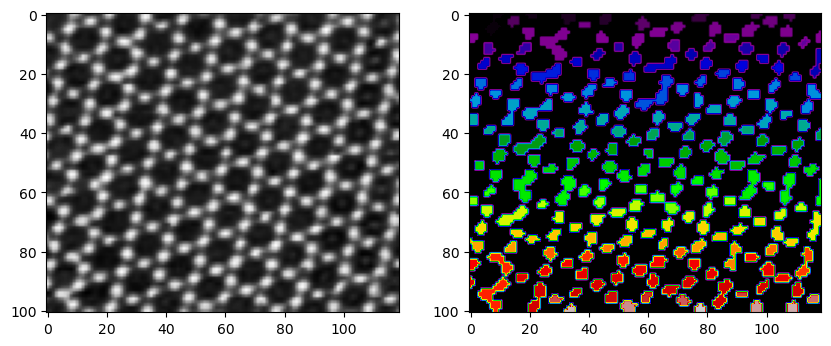

7/7 [==============================] - 0s 3ms/step


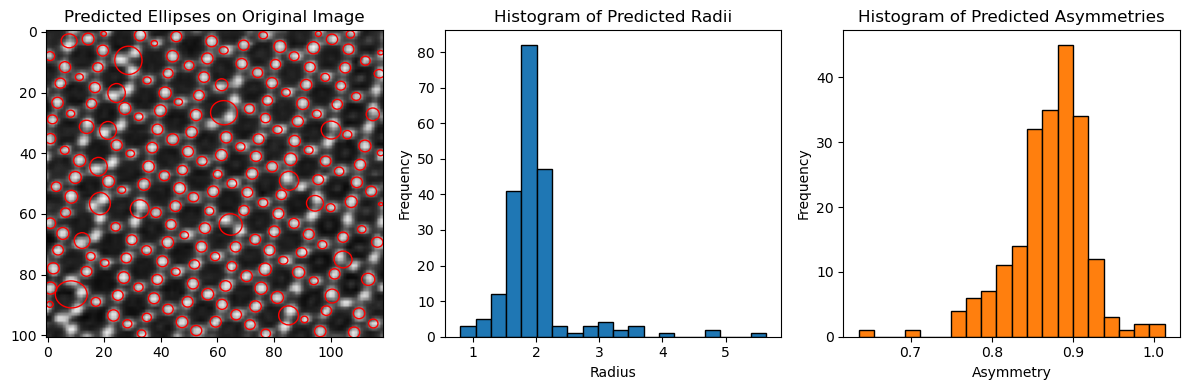

In [3]:

# Function to load and preprocess an image
def load_image(path):
    image = io.imread(path, as_gray=True)
    image = abs(image - 1)
    return image

def resize(image, size=32):
    rescale_factor = max(size / image.shape[0], size / image.shape[1])
    image = transform.resize(image, (int(image.shape[0] * rescale_factor), int(image.shape[1] * rescale_factor)), anti_aliasing=True)
    image = image[:size, :size]
    return image, rescale_factor

def segment_image(image, plot=False):
    blurred = filters.gaussian(image, sigma=0)
    threshold = filters.threshold_otsu(blurred)
    binary = blurred > threshold
    cleaned = morphology.remove_small_objects(binary, min_size=5)
    labeled_image = measure.label(cleaned)
    
    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(image, cmap='gray')
        ax[1].imshow(labeled_image, cmap='nipy_spectral')
        plt.show()
    
    return labeled_image

def extract_circles(labeled_image, original_image, plot=False):
    circles, scales, bboxes = [], [], []
    props = measure.regionprops(labeled_image)
    
    if plot:
        fig, ax = plt.subplots()
        ax.imshow(original_image, cmap='gray', vmin=0, vmax=1)
    
    for prop in props:
        y0, x0 = prop.centroid
        minr, minc, maxr, maxc = prop.bbox
        circle = original_image[minr:maxr, minc:maxc]
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        
        if plot:
            ax.plot(bx, by, '-r', linewidth=0.5)
            ax.plot(x0, y0, 'o', ms=1, color='red')

        circle, rescale_factor = resize(circle)
        circles.append(circle)
        scales.append(rescale_factor)
        bboxes.append((minr, minc, maxr, maxc))
    
    if plot:
        plt.show()
    
    return circles, scales, bboxes

# Function to visualize predictions and plot histograms
def visualize_predictions_and_histograms(original_image, X_test, scales, bboxes):
    radii, asymmetries = [], []
    
    # Predict all at once
    pred_labels = model.predict(X_test)
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    ax[0].imshow(original_image, cmap='gray', vmin=0, vmax=1, aspect="auto")
    
    for idx in range(len(X_test)):
        scale = scales[idx]
        bbox = bboxes[idx]
        minr, minc, maxr, maxc = bbox
        pred_label = pred_labels[idx]
        
        # Extract the predicted parameters
        pred_radius = pred_label[0] / scale
        pred_asymmetry = pred_label[1]
        pred_center_x = (pred_label[2] / scale) + minr
        pred_center_y = (pred_label[3] / scale) + minc
        pred_rotation = pred_label[4]  # Assuming the model provides rotation
        
        radii.append(pred_radius)
        asymmetries.append(pred_asymmetry)

        # Create an Ellipse patch
        ellipse = patches.Ellipse((pred_center_y, pred_center_x), 
                                  width=pred_radius * 2, 
                                  height=pred_asymmetry * pred_radius * 2, 
                                  angle=pred_rotation, 
                                  edgecolor='r', 
                                  facecolor='none')
        
        ax[0].add_patch(ellipse)
        
    ax[0].set_title('Predicted Ellipses on Original Image')
    
    # Plot histograms
    ax[1].hist(radii, bins=20, color='C0', edgecolor='black')
    ax[1].set_title('Histogram of Predicted Radii')
    ax[1].set_xlabel('Radius')
    ax[1].set_ylabel('Frequency')
    
    ax[2].hist(asymmetries, bins=20, color='C1', edgecolor='black')
    ax[2].set_title('Histogram of Predicted Asymmetries')
    ax[2].set_xlabel('Asymmetry')
    ax[2].set_ylabel('Frequency')
    
    fig.tight_layout()

# Load and preprocess the image
path = 'Picture1.png'
image = load_image(path)
segmented_image = segment_image(image, plot=True)
extracted_circles, extracted_scales, extracted_bboxes = extract_circles(segmented_image, image, plot=False)

X_test = np.array(extracted_circles).reshape(-1, extracted_circles[0].shape[0], extracted_circles[0].shape[1], 1)

visualize_predictions_and_histograms(image, X_test, extracted_scales, extracted_bboxes)